# BT4012 Project: Model Building, Tuning, and Evaluation
### Completed by: Group 8

# Import Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Initialize the evaluator
from model_evaluator import ModelEvaluator
evaluator = ModelEvaluator()

from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score

# Global Variables
RANDOM_STATE = 42

# Load Datasets & Basic EDA

#### Train set

In [2]:
train_df = pd.read_csv('../data/processed/train.csv')
train_df.head()

,category_grocery_pos,category_shopping_net,trans_timeofday_afternoon,trans_timeofday_evening,trans_timeofday_morning,trans_timeofday_night,amt,dist_from_last_trans,merchant,time_since_last_trans,trans_hour,trans_isworkhours,is_fraud
0,0.0,1.0,0.0,0.0,0.0,1.0,0.000011,0.214939,0.002540,0.004717,1.000000,0,0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.000508,0.579818,0.002287,0.016741,0.652174,1,0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.000631,0.534537,0.001380,0.026992,0.695652,1,0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.005356,0.242022,0.001711,0.089617,0.434783,1,0
4,1.0,0.0,0.0,0.0,1.0,0.0,0.014015,0.671043,0.003447,0.004334,0.347826,1,0


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232668 entries, 0 to 232667
Data columns (total 13 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   category_grocery_pos       232668 non-null  float64
 1   category_shopping_net      232668 non-null  float64
 2   trans_timeofday_afternoon  232668 non-null  float64
 3   trans_timeofday_evening    232668 non-null  float64
 4   trans_timeofday_morning    232668 non-null  float64
 5   trans_timeofday_night      232668 non-null  float64
 6   amt                        232668 non-null  float64
 7   dist_from_last_trans       232668 non-null  float64
 8   merchant                   232668 non-null  float64
 9   time_since_last_trans      232668 non-null  float64
 10  trans_hour                 232668 non-null  float64
 11  trans_isworkhours          232668 non-null  int64  
 12  is_fraud                   232668 non-null  int64  
dtypes: float64(11), int64(2)
memo

#### Validation set

In [4]:
validation_df = pd.read_csv('../data/processed/validation.csv')
validation_df.head()

,category_grocery_pos,category_shopping_net,trans_timeofday_afternoon,trans_timeofday_evening,trans_timeofday_morning,trans_timeofday_night,amt,dist_from_last_trans,merchant,time_since_last_trans,trans_hour,trans_isworkhours,is_fraud
0,0.0,0.0,1.0,0.0,0.0,0.0,0.018751,0.360518,0.000808,0.204182,0.608696,1,0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.000370,0.587510,0.000830,0.043286,0.913043,0,0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.000746,0.427590,0.001023,0.024188,1.000000,0,0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.000356,0.442112,0.003180,0.369554,0.608696,1,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.000128,0.487675,0.001092,0.026658,0.565217,1,0


In [5]:
validation_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   category_grocery_pos       30000 non-null  float64
 1   category_shopping_net      30000 non-null  float64
 2   trans_timeofday_afternoon  30000 non-null  float64
 3   trans_timeofday_evening    30000 non-null  float64
 4   trans_timeofday_morning    30000 non-null  float64
 5   trans_timeofday_night      30000 non-null  float64
 6   amt                        30000 non-null  float64
 7   dist_from_last_trans       30000 non-null  float64
 8   merchant                   30000 non-null  float64
 9   time_since_last_trans      30000 non-null  float64
 10  trans_hour                 30000 non-null  float64
 11  trans_isworkhours          30000 non-null  int64  
 12  is_fraud                   30000 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 3.0 MB


#### Test set

In [6]:
test_df = pd.read_csv('../data/processed/test.csv')
test_df.head()

,category_grocery_pos,category_shopping_net,trans_timeofday_afternoon,trans_timeofday_evening,trans_timeofday_morning,trans_timeofday_night,amt,dist_from_last_trans,merchant,time_since_last_trans,trans_hour,trans_isworkhours,is_fraud
0,0.0,0.0,1.0,0.0,0.0,0.0,0.002465,0.216631,0.000765,0.057390,0.521739,1,0
1,1.0,0.0,0.0,0.0,1.0,0.0,0.013654,0.308795,0.002794,0.105005,0.217391,0,0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.003374,0.225573,0.000408,0.028884,0.217391,0,0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.005874,0.401045,0.000830,0.091167,0.782609,1,0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.002706,0.624411,0.001057,0.045945,0.565217,1,0


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   category_grocery_pos       30000 non-null  float64
 1   category_shopping_net      30000 non-null  float64
 2   trans_timeofday_afternoon  30000 non-null  float64
 3   trans_timeofday_evening    30000 non-null  float64
 4   trans_timeofday_morning    30000 non-null  float64
 5   trans_timeofday_night      30000 non-null  float64
 6   amt                        30000 non-null  float64
 7   dist_from_last_trans       30000 non-null  float64
 8   merchant                   30000 non-null  float64
 9   time_since_last_trans      30000 non-null  float64
 10  trans_hour                 30000 non-null  float64
 11  trans_isworkhours          30000 non-null  int64  
 12  is_fraud                   30000 non-null  int64  
dtypes: float64(11), int64(2)
memory usage: 3.0 MB


#### Splitting into X and y

In [8]:
# split train df, validation df, test df into each of their X and y
y_train = train_df.pop('is_fraud')
X_train = train_df

y_valid = validation_df.pop('is_fraud')
X_valid = validation_df

y_test = test_df.pop('is_fraud')
X_test = test_df

In [9]:
X_train

,category_grocery_pos,category_shopping_net,trans_timeofday_afternoon,trans_timeofday_evening,trans_timeofday_morning,trans_timeofday_night,amt,dist_from_last_trans,merchant,time_since_last_trans,trans_hour,trans_isworkhours
0,0.0,1.0,0.0,0.0,0.0,1.0,0.000011,0.214939,0.002540,0.004717,1.000000,0
1,0.0,1.0,1.0,0.0,0.0,0.0,0.000508,0.579818,0.002287,0.016741,0.652174,1
2,0.0,0.0,1.0,0.0,0.0,0.0,0.000631,0.534537,0.001380,0.026992,0.695652,1
3,0.0,0.0,0.0,0.0,1.0,0.0,0.005356,0.242022,0.001711,0.089617,0.434783,1
4,1.0,0.0,0.0,0.0,1.0,0.0,0.014015,0.671043,0.003447,0.004334,0.347826,1
...,...,...,...,...,...,...,...,...,...,...,...,...
232663,0.0,0.0,0.0,0.0,0.0,1.0,0.000378,0.000000,0.000636,0.000000,0.130435,0
232664,0.0,0.0,0.0,0.0,0.0,1.0,0.056439,0.000000,0.001517,0.000000,0.130435,0
232665,1.0,0.0,0.0,1.0,0.0,0.0,0.018976,0.000000,0.004169,0.000000,0.782609,1
232666,0.0,1.0,0.0,0.0,0.0,1.0,0.075326,0.000000,0.003099,0.000000,1.000000,0


# Model Building & Hyperparameter Tuning

### Steps
- Choose a model: LogisticRegression, RidgeClassifier, SGDClassifier, KNeighborsClassifier, SVC, GaussianNB, DecisionTreeClassifier, HistGradientBoostingClassifier, RandomForestClassifier, VotingClassifier, StackingClassifier, AdaBoostClassifier, XGBClassifier
- Fit the model to the train set
- Get model's predictions for the train and validation set
- Use RandomizedSearchCV for K-fold Cross-Validation and Hyperparameter Tuning such that model performance can be optimised while preventing overfitting
- Repeat the steps above for other models

#### Baseline Model (DummyClassifier with 'prior' strategy)
DummyClassifier that will always predict the most frequent class label

In [10]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="prior", random_state=42)
dummy_clf.fit(X_train, y_train)

DummyClassifier(random_state=42)

In [11]:
# evaluate model performance on the validation set for hyperparameter tuning
y_valpred_dummy = dummy_clf.predict(X_valid)
y_valpred_prob_dummy = dummy_clf.predict_proba(X_valid)[:, 1]

evaluator.evaluate_model(
    model_name="Baseline Model",
    y_actual=y_valid,
    y_pred=y_valpred_dummy,
    y_pred_prob=y_valpred_prob_dummy,
    dataset_name="Validation"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
Baseline Model,0.9942,0.0,0.0,0.0,0.5,0.0058


#### Logistic Regression

In [12]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, randint

# create parameter grid
logreg_param_l1l2 = {
    'C': uniform(0.001, 10.0),
    'penalty': ['l1', 'l2'],
    'solver': ['saga'],
    'max_iter': [1000],
    'class_weight': ['balanced', None]
}

logreg_param_elasticnet = {
    'C': uniform(0.001, 10.0),
    'penalty': ['elasticnet'],
    'solver': ['saga'],
    'l1_ratio': uniform(0, 1),
    'max_iter': [1000],
    'class_weight': ['balanced', None]
}

logreg_param_distributions = [logreg_param_l1l2, logreg_param_elasticnet]

# create model and perform randomized search
logreg_clf = LogisticRegression(random_state=42)

logreg_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logreg_random_search = RandomizedSearchCV(
    logreg_clf, param_distributions=logreg_param_distributions,
    n_iter=50, cv=logreg_cv, scoring='roc_auc',
    random_state=42, n_jobs=-1
)

# fit model to train set
logreg_random_search.fit(X_train, y_train)

/Users/guest2/github/BT4012/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/guest2/github/BT4012/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/guest2/github/BT4012/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/guest2/github/BT4012/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/guest2/github/BT4012/venv/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/guest2/g

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=LogisticRegression(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions=[{'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x1278f90d0>,
                                         'class_weight': ['balanced', None],
                                         'max_iter': [1000],
                                         'penalty': ['l1', 'l2'],
                                         'solver': ['saga']},
                                        {'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x127a1dd00>,
                                         'class_weight': ['balanced', None],
                                         'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x127dc3860>,
                                         'max_iter': [1000],
                                         'penalty': ['elasticnet'],
                                         'solver': ['saga']}],
                   random_state=42, scoring='roc_auc')

In [13]:
# evaluate model performance on the validation set for hyperparameter tuning
y_valpred_logreg = logreg_random_search.best_estimator_.predict(X_valid)
y_valpred_prob_logreg = logreg_random_search.best_estimator_.predict_proba(X_valid)[:, 1]

evaluator.evaluate_model(
    model_name="LogisticRegression",
    y_actual=y_valid,
    y_pred=y_valpred_logreg,
    y_pred_prob=y_valpred_prob_logreg,
    dataset_name="Validation"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
LogisticRegression,0.958533,0.041166,0.275862,0.071642,0.636957,0.093073


#### SGDClassifier

In [14]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, randint

# create parameter grid
sgd_param_distributions = {
    'loss': ['log_loss', 'modified_huber'],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': uniform(1e-5, 1),
    'l1_ratio': uniform(0, 1),
    'max_iter': [1000],
    'learning_rate': ['optimal', 'adaptive'],
    'class_weight': ['balanced', None]
}

# create model and perform randomized search
sgd_clf = SGDClassifier(random_state=42)

sgd_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
sgd_random_search = RandomizedSearchCV(
    sgd_clf, param_distributions=sgd_param_distributions,
    n_iter=50, cv=sgd_cv, scoring='roc_auc',
    random_state=42, n_jobs=-1
)

# fit model to train set
sgd_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=SGDClassifier(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x10a5f7ad0>,
                                        'class_weight': ['balanced', None],
                                        'l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x127deddc0>,
                                        'learning_rate': ['optimal',
                                                          'adaptive'],
                                        'loss': ['log_loss', 'modified_huber'],
                                        'max_iter': [1000],
                                        'penalty': ['l1', 'l2', 'elasticnet']},
                   random_state=42, scoring='roc_auc')

In [15]:
# evaluate model performance on the validation set for hyperparameter tuning
y_valpred_sgd = sgd_random_search.best_estimator_.predict(X_valid)
y_valpred_prob_sgd = sgd_random_search.best_estimator_.predict_proba(X_valid)[:, 1]

evaluator.evaluate_model(
    model_name="SGDClassifier",
    y_actual=y_valid,
    y_pred=y_valpred_sgd,
    y_pred_prob=y_valpred_prob_sgd,
    dataset_name="Validation"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
SGDClassifier,0.894667,0.022393,0.402299,0.042424,0.755988,0.067819


#### RidgeClassifier

In [16]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, randint

# create parameter grid
ridge_param_distributions = {
    'alpha': uniform(0.1, 10.0),
    'class_weight': ['balanced', None]
}

# create model and perform randomized search
ridge_clf = RidgeClassifier(random_state=42)

ridge_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ridge_random_search = RandomizedSearchCV(
    ridge_clf, param_distributions=ridge_param_distributions,
    n_iter=50, cv=ridge_cv, scoring='roc_auc',
    random_state=42, n_jobs=-1
)

# fit model to train set
ridge_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RidgeClassifier(random_state=42), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x103dcc650>,
                                        'class_weight': ['balanced', None]},
                   random_state=42, scoring='roc_auc')

In [17]:
# evaluate model performance on the validation set for hyperparameter tuning
y_valpred_ridge = ridge_random_search.best_estimator_.predict(X_valid)
y_valpred_dec_ridge = ridge_random_search.best_estimator_.decision_function(X_valid)

evaluator.evaluate_model(
    model_name="RidgeClassifier",
    y_actual=y_valid,
    y_pred=y_valpred_ridge,
    y_pred_prob=None,
    y_pred_dec=y_valpred_dec_ridge,
    dataset_name="Validation"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
RidgeClassifier,0.954767,0.053585,0.408046,0.09473,0.760231,0.094615


#### KNeighborsClassifier

In [18]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import uniform, randint

# create parameter grid
kneigh_param_distributions = {
    'n_neighbors': randint(2, 5),
    'weights': ['uniform', 'distance'],
    'p': randint(1, 3)
}

# create model and perform randomized search
kneigh_clf = KNeighborsClassifier()

kneigh_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
kneigh_random_search = RandomizedSearchCV(
    kneigh_clf, param_distributions=kneigh_param_distributions,
    n_iter=50, cv=kneigh_cv, scoring='roc_auc',
    random_state=42, n_jobs=-1
)

# fit model to train set
kneigh_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=KNeighborsClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'n_neighbors': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x12787b320>,
                                        'p': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x10a768e60>,
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='roc_auc')

In [19]:
# evaluate model performance on the validation set for hyperparameter tuning
y_valpred_kneigh = kneigh_random_search.best_estimator_.predict(X_valid)
y_valpred_prob_kneigh = kneigh_random_search.best_estimator_.predict_proba(X_valid)[:, 1]

evaluator.evaluate_model(
    model_name="KNeighborsClassifier",
    y_actual=y_valid,
    y_pred=y_valpred_kneigh,
    y_pred_prob=y_valpred_prob_kneigh,
    dataset_name="Validation"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
KNeighborsClassifier,0.981867,0.131474,0.37931,0.195266,0.761901,0.089977


#### SVC

#### GaussianNB

In [20]:
from sklearn.naive_bayes import GaussianNB

gnb_model = GaussianNB()

gnb_model.fit(X_train, y_train)

GaussianNB()

#### DecisionTreeClassifier

In [21]:
from sklearn.tree import DecisionTreeClassifier

decisiontree_model = DecisionTreeClassifier(
    max_depth=5, 
    min_samples_split=2, 
    min_samples_leaf=4, 
    random_state=RANDOM_STATE
)

decisiontree_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, random_state=42)

#### HistGradientBoostingClassifier

In [22]:
from sklearn.ensemble import HistGradientBoostingClassifier

# define the hyperparameter space
histgb_param_grid = {
    "learning_rate": (0.01, 0.1, 0.2),
    "max_iter": (100, 200, 300),
    "max_depth": [3, 5, 7],
}

histgb_model = HistGradientBoostingClassifier(random_state=RANDOM_STATE)

histgb_random_search = RandomizedSearchCV(
    histgb_model,
    param_distributions=histgb_param_grid,
    n_iter=50,
    scoring='roc_auc',
    cv=3,
    random_state=RANDOM_STATE,
    verbose=2,
    n_jobs=-1
)

# perform the search
histgb_random_search.fit(X_train, y_train)

# best parameters and best model
print("Best Parameters:", histgb_random_search.best_params_)
histgb_model = histgb_random_search.best_estimator_


Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=100; total time=   3.0s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=100; total time=   3.0s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=100; total time=   3.1s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=200; total time=   5.3s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=200; total time=   5.3s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=200; total time=   5.4s
[CV] END ......learning_rate=0.01, max_depth=5, max_iter=100; total time=   2.9s
[CV] END ......learning_rate=0.01, max_depth=5, max_iter=100; total time=   3.2s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=300; total time=   7.9s
[CV] END ......learning_rate=0.01, max_depth=3, max_iter=300; total time=   8.0s
[CV] END ......learning_rate=0.01, max_depth=5, max_iter=100; total time=   3.7s
[CV] END ......learning_rate=0.01, max_depth=3, 

In [23]:
# evaluate model performance on the validation set for hyperparameter tuning
y_valpred_histgb = histgb_model.predict(X_valid)
y_valpred_prob_histgb = histgb_model.predict_proba(X_valid)[:, 1]

evaluator.evaluate_model(
    model_name="HistGB",
    y_actual=y_valid,
    y_pred=y_valpred_histgb,
    y_pred_prob=y_valpred_prob_histgb,
    dataset_name="Validation"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
HistGB,0.9898,0.329016,0.729885,0.453571,0.983933,0.478668


#### RandomForestClassifier

In [24]:
from sklearn.ensemble import RandomForestClassifier

# define the hyperparameter space
rf_param_grid = {
    "n_estimators": (100, 300),
    "max_depth": [3, 5, 10],
    "min_samples_leaf": (2, 6, 10),
}

rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

rf_random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=rf_param_grid,
    n_iter=50,          
    scoring="roc_auc",  
    cv=3,               
    random_state=RANDOM_STATE,
    verbose=2,
    n_jobs=-1           
)

# perform the search
rf_random_search.fit(X_train, y_train)

# best parameters and best model
print("Best Parameters:", rf_random_search.best_params_)
rf_model = rf_random_search.best_estimator_

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ..max_depth=3, min_samples_leaf=2, n_estimators=100; total time=   4.0s
[CV] END ..max_depth=3, min_samples_leaf=6, n_estimators=100; total time=   4.1s
[CV] END ..max_depth=3, min_samples_leaf=2, n_estimators=100; total time=   5.4s
[CV] END ..max_depth=3, min_samples_leaf=2, n_estimators=100; total time=   5.4s
[CV] END ..max_depth=3, min_samples_leaf=6, n_estimators=100; total time=   5.5s
[CV] END ..max_depth=3, min_samples_leaf=6, n_estimators=100; total time=   5.7s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   4.3s
[CV] END ..max_depth=3, min_samples_leaf=2, n_estimators=300; total time=  12.7s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   5.6s
[CV] END .max_depth=3, min_samples_leaf=10, n_estimators=100; total time=   5.6s
[CV] END ..max_depth=3, min_samples_leaf=2, n_estimators=300; total time=  16.2s
[CV] END ..max_depth=3, min_samples_leaf=2, n_es

In [25]:
# evaluate model performance on the validation set for hyperparameter tuning
y_valpred_rf = rf_model.predict(X_valid)
y_valpred_prob_rf = rf_model.predict_proba(X_valid)[:, 1]

evaluator.evaluate_model(
    model_name="RandomForest",
    y_actual=y_valid,
    y_pred=y_valpred_rf,
    y_pred_prob=y_valpred_prob_rf,
    dataset_name="Validation"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
RandomForest,0.965933,0.066462,0.373563,0.112847,0.944997,0.202761


#### XGBoost

In [26]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=RANDOM_STATE)

xgb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=xgb_param_grid,
    n_iter=20,
    scoring='f1',
    cv=5,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Fit search for XGBoost
xgb_search.fit(X_train, y_train)
print("Best Parameters:", xgb_search.best_params_)
xgb_model = xgb_search.best_estimator_

Best Parameters: {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.8}


In [27]:
y_valpred_xgb = xgb_model.predict(X_valid)
y_valpred_prob_xgb = xgb_model.predict_proba(X_valid)[:, 1]
evaluator.evaluate_model(
    model_name="XGBoost",
    y_actual=y_valid,
    y_pred=y_valpred_xgb,
    y_pred_prob=y_valpred_prob_xgb,
    dataset_name="Validation"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
XGBoost,0.9896,0.319372,0.701149,0.438849,0.984796,0.492858


#### AdaBoost

In [28]:
from sklearn.ensemble import AdaBoostClassifier

adaboost_param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0],
    # 'estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]
}

adaboost_hyper_model = AdaBoostClassifier(random_state=RANDOM_STATE)

# Create the RandomizedSearchCV
adaboost_search = RandomizedSearchCV(
    adaboost_hyper_model,
    param_distributions=adaboost_param_grid,
    n_iter=10,
    cv=3,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Fit the search for AdaBoost
adaboost_search.fit(X_train, y_train)
print("Best Parameters:", adaboost_search.best_params_)
adaboost_model = adaboost_search.best_estimator_


/Users/guest2/github/BT4012/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/guest2/github/BT4012/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/guest2/github/BT4012/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/guest2/github/BT4012/venv/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use t

Best Parameters: {'n_estimators': 150, 'learning_rate': 1.0}


In [29]:
y_valpred_adaboost = adaboost_model.predict(X_valid)
y_valpred_prob_adaboost = adaboost_model.predict_proba(X_valid)[:, 1]

evaluator.evaluate_model(
    model_name="AdaBoost",
    y_actual=y_valid,
    y_pred=y_valpred_adaboost,
    y_pred_prob=y_valpred_prob_adaboost,
    dataset_name="Validation"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
AdaBoost,0.9799,0.169492,0.632184,0.267315,0.969189,0.273425


#### VotingClassifier

In [30]:
from sklearn.ensemble import VotingClassifier

estimator = [
    ('histgb', histgb_model),
    ('xgb', xgb_model),
    ('adaboost', adaboost_model)
]

voting_model = VotingClassifier(
    estimators=estimator,
    voting='soft'
)

voting_model.fit(X_train, y_train)

VotingClassifier(estimators=[('histgb',
                              HistGradientBoostingClassifier(max_depth=7,
                                                             max_iter=300,
                                                             random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=...
                                            learning_rate=0.2, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=7,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=42, ...)),
                             ('adaboost',
                              AdaBoostClassifier(n_estimators=150,
                                                 random_state=42))],
                 voting='soft')

In [31]:
# evaluate model performance on the validation set for hyperparameter tuning
y_valpred_voting = voting_model.predict(X_valid)
y_valpred_prob_voting = voting_model.predict_proba(X_valid)[:, 1]

evaluator.evaluate_model(
    model_name="Voting",
    y_actual=y_valid,
    y_pred=y_valpred_voting,
    y_pred_prob=y_valpred_prob_voting,
    dataset_name="Validation"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
Voting,0.989933,0.329787,0.712644,0.450909,0.983752,0.454076


#### Stacking Classifier

In [32]:
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


# Define base models
base_learners = [
    ('histgb', histgb_model),
    ('xgb', xgb_model),
    ('adaboost', adaboost_model)
]

# Define meta-model (classifier to combine base models' predictions)
meta_model = LogisticRegression()

stacking_model = StackingClassifier(
    estimators=base_learners, 
    final_estimator=meta_model
)

stacking_model.fit(X_train, y_train)

StackingClassifier(estimators=[('histgb',
                                HistGradientBoostingClassifier(max_depth=7,
                                                               max_iter=300,
                                                               random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=0.8, device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamm...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None, max_depth=7,
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=42, ...)),
                               ('adaboost',
                                AdaBoostClassifier(n_estimators=150,
                                                   random_state=42))],
                   final_estimator=LogisticRegression())

In [33]:
y_valpred_stacking = stacking_model.predict(X_valid)
y_valpred_prob_stacking = stacking_model.predict_proba(X_valid)[:, 1]

evaluator.evaluate_model(
    model_name="Stacking",
    y_actual=y_valid,
    y_pred=y_valpred_stacking,
    y_pred_prob=y_valpred_prob_stacking,
    dataset_name="Validation"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
Stacking,0.988367,0.296984,0.735632,0.42314,0.876591,0.324587


#### All models on validation

In [34]:
evaluator.display_results(dataset_name="Validation")

,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
0,Baseline Model,0.994200,0.000000,0.000000,0.000000,0.500000,0.005800
1,LogisticRegression,0.958533,0.041166,0.275862,0.071642,0.636957,0.093073
2,SGDClassifier,0.894667,0.022393,0.402299,0.042424,0.755988,0.067819
3,RidgeClassifier,0.954767,0.053585,0.408046,0.094730,0.760231,0.094615
4,KNeighborsClassifier,0.981867,0.131474,0.379310,0.195266,0.761901,0.089977
5,HistGB,0.989800,0.329016,0.729885,0.453571,0.983933,0.478668
6,RandomForest,0.965933,0.066462,0.373563,0.112847,0.944997,0.202761
7,XGBoost,0.989600,0.319372,0.701149,0.438849,0.984796,0.492858
8,AdaBoost,0.979900,0.169492,0.632184,0.267315,0.969189,0.273425
9,Voting,0.989933,0.329787,0.712644,0.450909,0.983752,0.454076


# Model Evaluation

### Steps
- Get a model's predictions for the test set
- From the test set predictions, compute scores for evaluation metrics such as Accuracy, Precision, Recall, F1-Score, ROC AUC
- Repeat the steps above for other models
- Consolidate the evaluation scores for all the models in a table for comparison
- Determine the best performing model for our project’s use case

#### Baseline Model (DummyClassifier with 'prior' strategy)
DummyClassifier that will always predict the most frequent class label

In [35]:
y_testpred_dummy = dummy_clf.predict(X_test)
y_testpred_prob_dummy = dummy_clf.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="Baseline Model",
    y_actual=y_test,
    y_pred=y_testpred_dummy,
    y_pred_prob=y_testpred_prob_dummy,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
Baseline Model,0.996133,0.0,0.0,0.0,0.5,0.003867


#### LogisticRegression

In [36]:
y_testpred_logreg = logreg_random_search.best_estimator_.predict(X_test)
y_testpred_prob_logreg = logreg_random_search.best_estimator_.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="LogisticRegression",
    y_actual=y_test,
    y_pred=y_testpred_logreg,
    y_pred_prob=y_testpred_prob_logreg,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
LogisticRegression,0.9477,0.020462,0.267241,0.038013,0.621116,0.033364


#### SGDClassifier

In [37]:
y_testpred_sgd = sgd_random_search.best_estimator_.predict(X_test)
y_testpred_prob_sgd = sgd_random_search.best_estimator_.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="SGDClassifier",
    y_actual=y_test,
    y_pred=y_testpred_sgd,
    y_pred_prob=y_testpred_prob_sgd,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
SGDClassifier,0.881567,0.013586,0.413793,0.026309,0.748741,0.047999


#### RidgeClassifier

In [38]:
y_testpred_ridge = ridge_random_search.best_estimator_.predict(X_test)
y_testpred_dec_ridge = ridge_random_search.best_estimator_.decision_function(X_test)

evaluator.evaluate_model(
    model_name="RidgeClassifier",
    y_actual=y_test,
    y_pred=y_testpred_ridge,
    y_pred_prob=None,
    y_pred_dec=y_testpred_dec_ridge,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
RidgeClassifier,0.934867,0.023834,0.396552,0.044966,0.768446,0.048321


#### KNeighborsClassifier

In [39]:
y_testpred_kneigh = kneigh_random_search.best_estimator_.predict(X_test)
y_testpred_prob_kneigh = kneigh_random_search.best_estimator_.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="KNeighborsClassifier",
    y_actual=y_test,
    y_pred=y_testpred_kneigh,
    y_pred_prob=y_testpred_prob_kneigh,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
KNeighborsClassifier,0.980867,0.083636,0.396552,0.138138,0.747191,0.052972


#### SVC

#### GaussianNB

In [40]:
y_testpred_gnb = gnb_model.predict(X_test)
y_testpred_prob_gnb = gnb_model.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="GaussianNB",
    y_actual=y_test,
    y_pred=y_testpred_gnb,
    y_pred_prob=y_testpred_prob_gnb,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
GaussianNB,0.929733,0.020231,0.362069,0.038321,0.631031,0.052107


#### DecisionTreeClassifier

In [41]:
y_testpred_dt = decisiontree_model.predict(X_test)
y_testpred_prob_dt = decisiontree_model.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="DecisionTree",
    y_actual=y_test,
    y_pred=y_testpred_dt,
    y_pred_prob=y_testpred_prob_dt,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
DecisionTree,0.9681,0.045405,0.362069,0.080692,0.824058,0.20298


#### HistGradientBoostingClassifier

In [42]:
y_testpred_histgb = histgb_model.predict(X_test)
y_testpred_prob_histgb = histgb_model.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="HistGB",
    y_actual=y_test,
    y_pred=y_testpred_histgb,
    y_pred_prob=y_testpred_prob_histgb,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
HistGB,0.9884,0.194737,0.637931,0.298387,0.970087,0.305217


#### RandomForestClassifier

In [43]:
y_testpred_rf = rf_model.predict(X_test)
y_testpred_prob_rf = rf_model.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="RandomForest",
    y_actual=y_test,
    y_pred=y_testpred_rf,
    y_pred_prob=y_testpred_prob_rf,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
RandomForest,0.9654,0.037149,0.318966,0.066547,0.924264,0.085853


#### XGBoost

In [44]:
y_testpred_xgb = xgb_model.predict(X_test)
y_testpred_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
evaluator.evaluate_model(
    model_name="XGBoost",
    y_actual=y_test,
    y_pred=y_testpred_xgb,
    y_pred_prob=y_testpred_prob_xgb,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
XGBoost,0.988133,0.190722,0.637931,0.293651,0.973103,0.317268


#### AdaBoost

In [45]:
y_testpred_adaboost = adaboost_model.predict(X_test)
y_testpred_prob_adaboost = adaboost_model.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="AdaBoost",
    y_actual=y_test,
    y_pred=y_testpred_adaboost,
    y_pred_prob=y_testpred_prob_adaboost,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
AdaBoost,0.977367,0.093795,0.560345,0.160692,0.948737,0.124486


#### VotingClassifier

In [46]:
y_testpred_voting = voting_model.predict(X_test)
y_testpred_prob_voting = voting_model.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="Voting",
    y_actual=y_test,
    y_pred=y_testpred_voting,
    y_pred_prob=y_testpred_prob_voting,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
Voting,0.9884,0.196335,0.646552,0.301205,0.970389,0.26575


#### Stacking Classifier

In [47]:
y_testpred_stacking = stacking_model.predict(X_test)
y_testpred_prob_stacking = stacking_model.predict_proba(X_test)[:, 1]

evaluator.evaluate_model(
    model_name="Stacking",
    y_actual=y_test,
    y_pred=y_testpred_stacking,
    y_pred_prob=y_testpred_prob_stacking,
    dataset_name="Test"
)

,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
Stacking,0.986533,0.175676,0.672414,0.278571,0.837633,0.229378


### All Models on Test

In [48]:
evaluator.display_results(dataset_name="Test")

,Model,Accuracy,Precision,Recall,F1-Score,ROC AUC,Average Precision
0,Baseline Model,0.996133,0.000000,0.000000,0.000000,0.500000,0.003867
1,LogisticRegression,0.947700,0.020462,0.267241,0.038013,0.621116,0.033364
2,SGDClassifier,0.881567,0.013586,0.413793,0.026309,0.748741,0.047999
3,RidgeClassifier,0.934867,0.023834,0.396552,0.044966,0.768446,0.048321
4,KNeighborsClassifier,0.980867,0.083636,0.396552,0.138138,0.747191,0.052972
5,GaussianNB,0.929733,0.020231,0.362069,0.038321,0.631031,0.052107
6,DecisionTree,0.968100,0.045405,0.362069,0.080692,0.824058,0.202980
7,HistGB,0.988400,0.194737,0.637931,0.298387,0.970087,0.305217
8,RandomForest,0.965400,0.037149,0.318966,0.066547,0.924264,0.085853
9,XGBoost,0.988133,0.190722,0.637931,0.293651,0.973103,0.317268


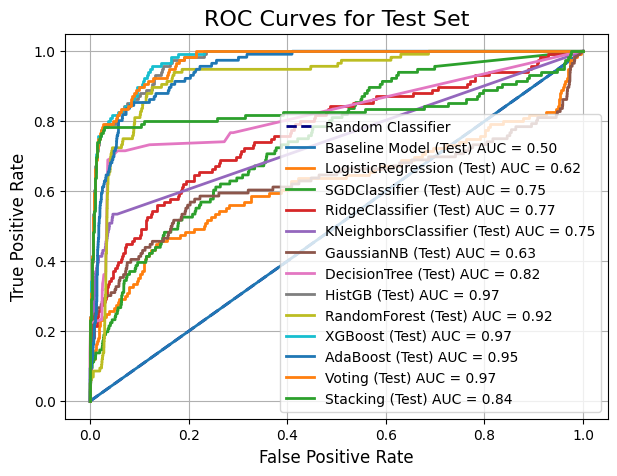

In [49]:
evaluator.plot_curves(curve_type='roc', dataset_name="Test")

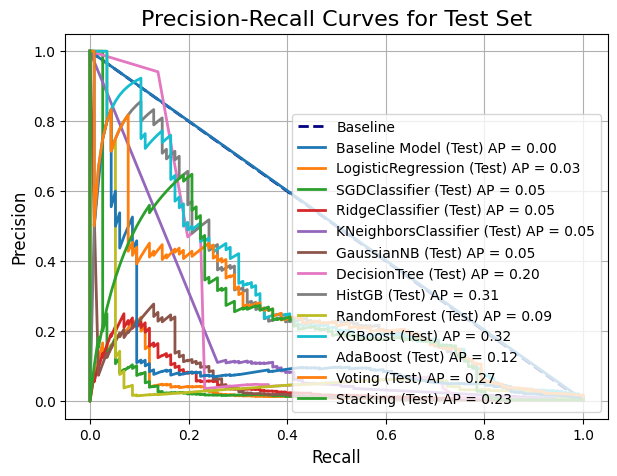

In [50]:
evaluator.plot_curves(curve_type='precision_recall', dataset_name="Test")